In [102]:
from custom_filter import * 

In [111]:
f = no_variance_filter
# --------------------------------------------------
base_dir = '../../outputs'
import json 
import os 
import numpy as np 
from omegaconf import OmegaConf 

results_in_directories = []
for root, dirs, files in os.walk(base_dir):
    if 'config.yaml' in files:
        flags = OmegaConf.load(os.path.join(root, 'config.yaml'))
        if not f(flags, 'grad', ['efficient_b0' ,'resnet18', 'vgg16']):
            continue
        print(flags)
        result = json.load(open(os.path.join(root, 'evaluation.json'), 'rb'))
        results_in_directories.append([flags, result])
        print(list(result.keys())[:10])
print(len(results_in_directories))


{'encoder': 'vgg16', 'data_path': '/data/ImageNet1k', 'bbox_path': '/data/ILSVRC2012_bbox_val', 'input_attrib': 'grad', 'fixed_samples': None, 'method': 'cls', 'device': 'cuda:0', 'layer_ratio': 1.0, 'alpha': None, 'save_name': 'True_0.1_1.0', 'quantile': 0.1, 'p_value_threshold': 0.05, 'variance_conservation': True, 'exact_variance': True, 'gamma_infinity': True, 'success': True}
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
{'encoder': 'vgg16', 'data_path': '/data/ImageNet1k', 'bbox_path': '/data/ILSVRC2012_bbox_val', 'input_attrib': 'grad', 'fixed_samples': None, 'method': 'cls', 'device': 'cuda:0', 'layer_ratio': 1.0, 'alpha': None, 'save_name': 'False_0.1_1.0', 'quantile': 0.1, 'p_value_threshold': 0.05, 'variance_conservation': False, 'exact_variance': True, 'gamma_infinity': True, 'success': True}
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
{'encoder': 'vgg16', 'data_path': '/data/ImageNet1k', 'bbox_path': '/data/ILSVRC2012_bbox_val', 'input_attrib': 'grad', 'fixed_s

In [112]:
N_samples = 50000

In [113]:
from tqdm import tqdm 

def custom_flag_condition(flag):
    condition = True 
    name = f"{flag.encoder}_{flags.method}_{flags.input_attrib}_{flag.layer_ratio}_{flag.quantile}_{flag.variance_conservation}"
    return name, condition 

condition_results = {}
for flag, results in tqdm(results_in_directories): 
    name, condition = custom_flag_condition(flag)
    if not condition :
        continue
    eval_results = {
        'morf_aopc' : {},
        'morf_lodds' :{},
        'morf_fracdiff' : {},
        'morf_acc' :{},
        'lerf_aopc' :{},
        'lerf_lodds' :{},
        'lerf_fracdiff' :{},
        'lerf_acc' :{},
        'mu_in':[],
        'mu_in_w':[],
    }
    assert name not in condition_results, f"{name} is already in condition_results. {flag}"
    reduced_eval_results =  {k:{} for k in eval_results.keys()}

    for idx in range(N_samples):
        for k, v in results[str(idx)].items():
            if k in ['morf', 'lerf']:
                for metric, ratio_results in v.items():
                    for ratio, value in ratio_results.items():
                        if ratio not in eval_results[f'{k}_{metric}']:
                            eval_results[f'{k}_{metric}'][float(ratio)] = []
                            reduced_eval_results[f'{k}_{metric}'][float(ratio)] = 0
                        eval_results[f'{k}_{metric}'][float(ratio)].append(float(value))
            elif k in ['mu_in_w', 'mu_in']:
                eval_results[k].append(float(v))
                
    for k, v in eval_results.items():
        if k in ['mu_in', 'mu_in_w'] :
            reduced_eval_results[f"{k}_mean"] = np.mean(v)
        else:
            for ratio, value in v.items():
                reduced_eval_results[f"{k}"][ratio] = np.mean(value)
            reduced_eval_results[f"{k}_ratio_mean"] = np.mean(list(reduced_eval_results[k].values()))
    condition_results[f'{name}'] = reduced_eval_results
    metric_names = [ k for k in  reduced_eval_results.keys() if 'mean' in k] 
    # print(f'{name}')

100%|██████████| 45/45 [02:37<00:00,  3.50s/it]


In [127]:
import re 
print("| name ", end=" |")
metric_names = [ k for k in  reduced_eval_results.keys() if 'mean' in k] 
keys = list(condition_results.keys())
keys = sorted(keys)

for k in metric_names:
    sub_name = re.sub('_mean', "", k)
    sub_name = re.sub('_ratio', "", sub_name)
    print(sub_name, end= " | ")

dfs = {
    'encoder':[],
    'method':[],
    'input_attrib':[],
    'layer_ratio':[],
    'quantile':[],
    'variance_conservation':[],
    }

print()
print("|---|", end=" ")
for k in metric_names:
    print("---", end= " | ")
    dfs[k] = []
print()
for key in keys:
    print(key, end=" | ")
    if 'efficient_b0' in key:
        keyr = key.replace('efficient_b0', 'efficient-b0')
    else:
        keyr =key 
    encoder, method, input_attrib, layer_ratio, quantile, variance_conservation = keyr.split("_")
    dfs['encoder'].append(encoder)
    dfs['method'].append(method)
    dfs['input_attrib'].append(input_attrib)
    dfs['layer_ratio'].append(layer_ratio)
    dfs['quantile'].append(quantile)
    dfs['variance_conservation'].append(variance_conservation)
    for k in metric_names:
        print(f"{condition_results[key][k]:.3f}", end=" | ")
        dfs[k].append(condition_results[key][k])
    print()

| name  |morf_aopc | morf_lodds | morf_fracdiff | morf_acc | lerf_aopc | lerf_lodds | lerf_fracdiff | lerf_acc | mu_in | mu_in_w | 
|---| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
efficient_b0_cls_grad_0.3_0.05_False | 0.357 | -3.552 | 0.357 | 0.167 | 0.153 | -0.859 | 0.208 | 0.667 | 0.523 | 0.950 | 
efficient_b0_cls_grad_0.3_0.05_True | -0.042 | 0.066 | 0.085 | 0.667 | -0.042 | 0.066 | 0.085 | 0.667 | nan | nan | 
efficient_b0_cls_grad_0.5_0.05_False | 0.352 | -3.801 | 0.352 | 0.167 | 0.105 | -0.448 | 0.156 | 0.667 | 0.527 | 0.960 | 
efficient_b0_cls_grad_0.5_0.05_True | -0.042 | 0.066 | 0.085 | 0.667 | -0.042 | 0.066 | 0.085 | 0.667 | nan | nan | 
efficient_b0_cls_grad_0.5_0.1_False | 0.351 | -2.936 | 0.351 | 0.167 | 0.146 | -1.070 | 0.183 | 0.667 | 0.528 | 0.956 | 
efficient_b0_cls_grad_0.9_0.05_False | 0.355 | -3.332 | 0.355 | 0.167 | 0.218 | -0.988 | 0.226 | 0.667 | 0.537 | 0.981 | 
efficient_b0_cls_grad_0.9_0.05_True | -0.042 | 0.066 | 0.085 | 0.667 | -0.042 | 

In [128]:
import pandas as pd 
df = pd.DataFrame(dfs)
df

,encoder,method,input_attrib,layer_ratio,quantile,variance_conservation,morf_aopc_ratio_mean,morf_lodds_ratio_mean,morf_fracdiff_ratio_mean,morf_acc_ratio_mean,lerf_aopc_ratio_mean,lerf_lodds_ratio_mean,lerf_fracdiff_ratio_mean,lerf_acc_ratio_mean,mu_in_mean,mu_in_w_mean
0,efficient-b0,cls,grad,0.3,0.05,False,0.357462,-3.551842,0.357462,0.166667,0.152765,-0.858766,0.208329,0.666667,0.522917,0.950252
1,efficient-b0,cls,grad,0.3,0.05,True,-0.041857,0.066441,0.085211,0.666667,-0.041857,0.066441,0.085211,0.666667,NaN,NaN
2,efficient-b0,cls,grad,0.5,0.05,False,0.352387,-3.801447,0.352387,0.166667,0.104996,-0.447909,0.156269,0.666667,0.526963,0.959801
3,efficient-b0,cls,grad,0.5,0.05,True,-0.041857,0.066441,0.085211,0.666667,-0.041857,0.066441,0.085211,0.666667,NaN,NaN
4,efficient-b0,cls,grad,0.5,0.1,False,0.350607,-2.936368,0.350607,0.166667,0.146043,-1.069631,0.182924,0.666667,0.528055,0.956116
5,efficient-b0,cls,grad,0.9,0.05,False,0.354882,-3.331869,0.354882,0.166667,0.217931,-0.988233,0.225832,0.666667,0.537133,0.980750
6,efficient-b0,cls,grad,0.9,0.05,True,-0.041857,0.066441,0.085211,0.666667,-0.041857,0.066441,0.085211,0.666667,NaN,NaN
7,efficient-b0,cls,grad,0.9,0.1,False,0.358919,-2.957639,0.358919,0.166667,0.276436,-1.974821,0.276436,0.500000,0.538255,0.978161
8,efficient-b0,cls,grad,0.9,0.1,True,-0.041857,0.066441,0.085211,0.666667,-0.041857,0.066441,0.085211,0.666667,NaN,NaN
9,efficient-b0,cls,grad,1.0,0.05,False,0.355943,-2.703675,0.355944,0.166667,0.358559,-3.454840,0.358559,0.166667,0.534509,0.971786


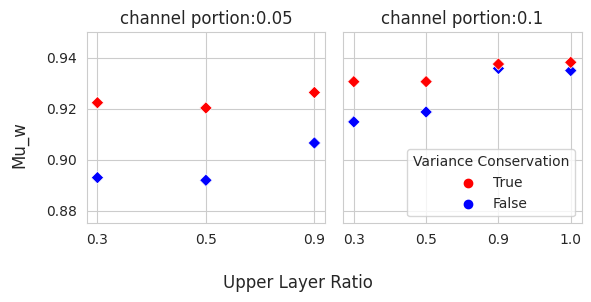

In [129]:
import seaborn as sns 
import matplotlib.pyplot as plt 
sns.set_style("whitegrid")
fig, axes = plt.subplots(1,2 ,figsize=(6,3))


qs = ['0.05', '0.1']

for q, ax in zip(qs, axes):
    t = df[(df['encoder']=='resnet18')&(df['input_attrib']=='grad')&(df['quantile']==q)]
    sns.scatterplot(x='layer_ratio', y='mu_in_w_mean', data=t, hue='variance_conservation', ax=ax, s=40, marker='D', palette=('red', 'blue'), hue_order=['True', 'False'])
    ax.set_ylim(0.875, 0.95)
    ax.set_title(f"channel portion:{q}")
    if q == '0.05':
        ax.get_legend().remove()
    else:
        ax.legend(loc='lower right', title='Variance Conservation')
        ax.set_yticklabels([])
    ax.set_ylabel(None)
    ax.set_xlabel(None)
fig.supylabel("Mu_w")
fig.supxlabel("Upper Layer Ratio")
plt.tight_layout()
plt.savefig("outputs/resnet18_mu.pdf")

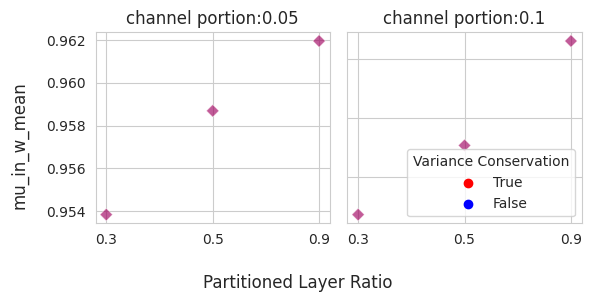

In [130]:
qs = ['0.05', '0.1']
fig, axes = plt.subplots(1,2 ,figsize=(6,3))

name='mu_in_w_mean'
for q, ax in zip(qs, axes):
    t = df[(df['encoder']=='vgg16')&(df['input_attrib']=='grad')&(df['quantile']==q)]
    sns.scatterplot(x='layer_ratio', y=name, data=t, hue='variance_conservation', ax=ax, s=40, marker='D', palette=('red', 'blue'), hue_order=['True', 'False'], alpha=0.4)
    # ax.set_ylim(0.875, 0.95)
    ax.set_title(f"channel portion:{q}")
    if q == '0.05':
        ax.get_legend().remove()
    else:
        ax.legend(loc='lower right', title='Variance Conservation')
        ax.set_yticklabels([])
    ax.set_ylabel(None)
    ax.set_xlabel(None)
fig.supylabel(name)
fig.supxlabel("Partitioned Layer Ratio")
plt.tight_layout()
plt.savefig("outputs/vgg16_mu.pdf")

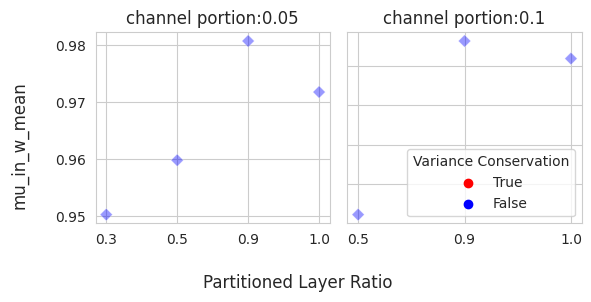

In [133]:
qs = ['0.05', '0.1']
fig, axes = plt.subplots(1,2 ,figsize=(6,3))

name='mu_in_w_mean'
for q, ax in zip(qs, axes):
    t = df[(df['encoder']=='efficient-b0')&(df['input_attrib']=='grad')&(df['quantile']==q)]
    sns.scatterplot(x='layer_ratio', y=name, data=t, hue='variance_conservation', ax=ax, s=40, marker='D', palette=('red', 'blue'), hue_order=['True', 'False'], alpha=0.4)
    # ax.set_ylim(0.875, 0.95)
    ax.set_title(f"channel portion:{q}")
    if q == '0.05':
        ax.get_legend().remove()
    else:
        ax.legend(loc='lower right', title='Variance Conservation')
        ax.set_yticklabels([])
    ax.set_ylabel(None)
    ax.set_xlabel(None)
fig.supylabel(name)
fig.supxlabel("Partitioned Layer Ratio")
plt.tight_layout()
plt.savefig("outputs/efficent_b0_mu.pdf")

In [132]:
key

'vgg16_cls_grad_1.0_0.1_True'